**Complete Modeling for Subgroup 3 - Performed by Aditya Kumaran**

I pledge my honor that I have abided by the Stevens Honor System.

In [105]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression


In [106]:
#Loading the Subgroup 3 Data

data = pd.read_csv("subgroub3.csv")
data.head()

data.shape




(2163, 98)

**Preprocessing**

*Goal is to perform feature reduction and have total features < 50*

In [107]:
#Dropping "Bankrupt" and "Index" columns

y = data["Bankrupt?"]

data = data.drop(["Bankrupt?", "Index", "cluster"], axis = 1)
data.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0.450397,0.504034,0.506986,0.594640,0.594640,0.998906,0.797293,0.809239,0.303489,0.781491,...,0.780554,0.004919,0.623634,0.594641,0.838869,0.279036,0.026788,0.565144,1,0.032464
1,0.476332,0.534507,0.526581,0.610985,0.609183,0.999041,0.797381,0.809312,0.303359,0.781570,...,0.796531,0.000552,0.623563,0.610984,0.840085,0.279004,0.044600,0.569915,1,0.032626
2,0.514113,0.566779,0.565341,0.613312,0.613312,0.999154,0.797618,0.809497,0.303536,0.781770,...,0.815698,0.003068,0.624210,0.613313,0.841336,0.277518,0.026847,0.565411,1,0.044359
3,0.474918,0.533689,0.529739,0.601976,0.601976,0.998962,0.797381,0.809315,0.303524,0.781567,...,0.796865,0.003257,0.623103,0.601978,0.840101,0.277650,0.037217,0.569733,1,0.042841
4,0.442500,0.507196,0.494941,0.598906,0.598812,0.998927,0.797298,0.809236,0.303453,0.781484,...,0.780905,0.009173,0.624087,0.598903,0.838903,0.278959,0.026643,0.564335,1,0.032862


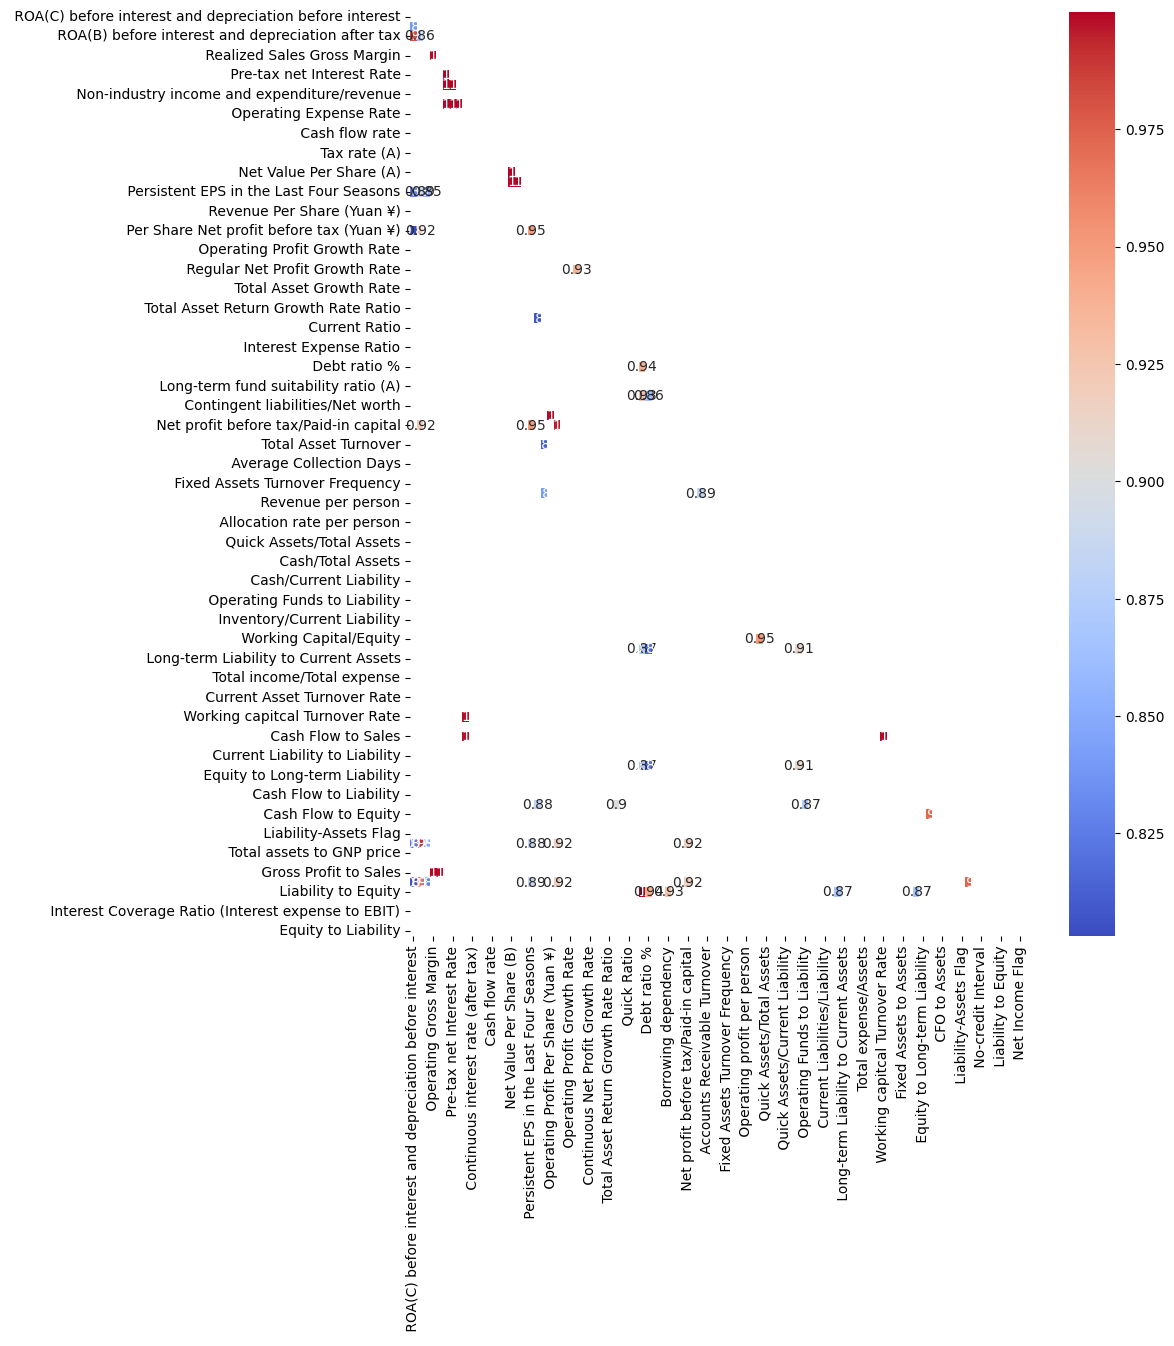

In [108]:
#Correlation Matrix showing correlations > .80

corr_matrix = data.corr()

threshold = 0.8
strong_corr = corr_matrix[(corr_matrix >= threshold) & (corr_matrix < 1.0)]

plt.figure(figsize = (10,12))
mask = np.triu(np.ones_like(strong_corr, dtype=bool))
sns.heatmap(strong_corr, mask=mask, cmap = 'coolwarm', annot = True)
plt.show()

In [109]:
# Compute correlation matrix
corr_matrix = data.corr().abs()

# Keep only upper triangle to avoid duplicate pairs (and self-correlation)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs with correlation above threshold
threshold = 0.8
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > threshold]

# Sort by correlation (descending)
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

high_corr_pairs

#saving pairs to colab for easier viewing
high_corr_pairs.to_csv('/content/high_corr_pairs.csv', index=False)


In [110]:
#removing features with high correlations

data.columns = data.columns.str.strip()


data = data.drop(["Debt ratio %", "Current Liability to Equity", "Current Liability to Liability", "Operating Gross Margin", "After-tax net Interest Rate", "Continuous interest rate (after tax)", "Working capitcal Turnover Rate", "Net Value Per Share (B)", "Net Value Per Share (C)", "Operating profit/Paid-in capital", "Operating Profit Rate", "Realized Sales Gross Margin", "Net profit before tax/Paid-in capital", "ROA(C) before interest and depreciation before interest", "ROA(A) before interest and % after tax", "Net Income to Stockholder's Equity", "Cash Flow to Equity", "Net worth/Assets", "After-tax Net Profit Growth Rate", "Borrowing dependency", "Net Income to Total Assets", "Current Liability to Assets", "Cash Reinvestment %", "Net Worth Turnover Rate (times)", "Cash Flow Per Share", "Operating Funds to Liability", "Total debt/Total net worth", "Liability to Equity", "Total Asset Turnover"], axis = 1)

print(data.shape, "-> we have reduced it to 66 features.")


(2163, 66) -> we have reduced it to 66 features.


In [111]:
#visualizing variance (we want to remove features with really low relative variance)

variance_table = data.var()
variance_table = variance_table.apply(lambda x: f"{x:.6f}")
variance_table = variance_table.sort_values(ascending = True)

print(variance_table)

variance_table.to_csv('/content/variance_table.csv') #for easier viewing in CoLab

Total Asset Return Growth Rate Ratio                       0.000000
Net Income Flag                                            0.000000
Net Value Growth Rate                                      0.000000
Liability-Assets Flag                                      0.000000
Continuous Net Profit Growth Rate                          0.000000
                                                    ...            
Total Asset Growth Rate                  5936067818008092672.000000
Interest-bearing debt interest rate         6303962687997530.000000
Research and development expense rate    6407832628062294016.000000
Cash Turnover Rate                       8489116896519519232.000000
Current Asset Turnover Rate              9292330605989744640.000000
Length: 66, dtype: object


In [112]:
#drop all features with variance lower than 0.0001

threshold = 0.0001
variance_below_threshold = []

for column in data.columns:
    if data[column].var() < threshold:
        variance_below_threshold.append(column)


data = data.drop(variance_below_threshold, axis = 1)
print(data.shape, "-> we have reduced it to 47 features.")

(2163, 47) -> we have reduced it to 47 features.


In [113]:
#Final Step: Let's apply PCA and try 35 features

#scale data
scaler = StandardScaler()


X_scaled = scaler.fit_transform(data)

#apply pca
pca = PCA(n_components=35)
data = pca.fit_transform(X_scaled)

print("Original Shape: ", X_scaled.shape)
print("PCA Shape: ", data.shape)

print("Total explained variance by 35 components: ", round(sum(pca.explained_variance_ratio_), 3))

Original Shape:  (2163, 47)
PCA Shape:  (2163, 35)
Total explained variance by 35 components:  0.951


# **Base Models Training + Stacking**

Training the base models and combining them using stacking.

# **Base Models selected (and reasoning)**


**K-Nearest Neighbors (KNN)**

Strength: Captures local structure, very intuitive.

Weakness: Sensitive to noisy data and irrelevant features.

Contribution to Ensemble: Provides local voting perspective, which differs from tree-based or kernel methods.

**Random Forest**

Strength: Handles high-dimensional data well, robust to noise, feature importance is useful.

Weakness: Can be biased if features are highly correlated.

Contribution to Ensemble: Captures complex interactions and feature importance, often performs well out-of-the-box.

**Support Vector Machine with RBF Kernel (SVM-RBF)**

Strength: Great for high-dimensional, non-linear decision boundaries.

Weakness: Computationally expensive for large datasets, sensitive to hyperparameters.

Contribution to Ensemble: Adds a smooth, margin-maximizing classifier that complements the greedy splits of trees and the instance-based nature of KNN.

In [114]:
#Making an accuracy score function

def class_accuracy_score(y_test, y_pred):
  correct = 0
  incorrect = 0

  for yt, yp in zip(y_test, y_pred):
    if yt == yp:
      correct += 1
    else:
      incorrect += 1

  if correct + incorrect == 0:
    return 0
  else:
    return correct / (correct + incorrect)

In [115]:
#Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [116]:
#Applying SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [117]:
#Training the base models
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = None)
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)


knn_clf = KNeighborsClassifier(n_neighbors = 3)
knn_clf.fit(X_train, y_train)
knn_y_pred = knn_clf.predict(X_test)


svm_rbf_clf = svm.SVC(kernel='rbf')
svm_rbf_clf.fit(X_train, y_train)
svm_rbf_y_pred = svm_rbf_clf.predict(X_test)

#Getting predictions on the train data
rf_train_pred = rf_clf.predict(X_train)
knn_train_pred = knn_clf.predict(X_train)
svm_train_pred = svm_rbf_clf.predict(X_train)

#Printing Some Statistics
num_bankrupt_real = 0
num_not_bankrupt_real = 0

for i in y_test:
  if i == 1:
    num_bankrupt_real += 1
  else:
    num_not_bankrupt_real += 1


print("Number of Bankrupts in Test Data: ", num_bankrupt_real)
print("Number of Not Bankrupts in Test Data: ", num_not_bankrupt_real)


num_bankrupt = 0
num_not_bankrupt = 0

for i in rf_y_pred:
  if i == 1:
    num_bankrupt += 1
  else:
    num_not_bankrupt += 1

print("Num Bankrupt predicted by RF: ", num_bankrupt)


num_bankrupt_1 = 0
num_not_bankrupt_1 = 0

for i in knn_y_pred:
  if i == 1:
    num_bankrupt_1 += 1
  else:
    num_not_bankrupt_1 += 1

print("Num Bankrupt predicted by KNN: ", num_bankrupt_1)


num_bankrupt_2 = 0
num_not_bankrupt_2 = 0

for i in svm_rbf_y_pred:
  if i == 1:
    num_bankrupt_2 += 1
  else:
    num_not_bankrupt_2 += 1

print("Num Bankrupt predicted by SVM: ", num_bankrupt_2)

#Accuracy Scores for Train/Test
rf_accuracy_score_test = class_accuracy_score(y_test, rf_y_pred)
knn_accuracy_score_test = class_accuracy_score(y_test, knn_y_pred)
svm_rbf_accuracy_score_test = class_accuracy_score(y_test, svm_rbf_y_pred)

rf_accuracy_score_train = class_accuracy_score(y_train, rf_train_pred)
knn_accuracy_score_train = class_accuracy_score(y_train, knn_train_pred)
svm_rbf_accuracy_score_train = class_accuracy_score(y_train, svm_train_pred)

#Reporting the Accuracy Scores
print()

print("Random Forest Accuracy Train:", rf_accuracy_score_train)
print("KNN Accuracy Train:", knn_accuracy_score_train)
print("SVM-RBF Accuracy Train:", svm_rbf_accuracy_score_train)

print()

print("Random Forest Accuracy Test:", rf_accuracy_score_test)
print("KNN Accuracy Test:", knn_accuracy_score_test)
print("SVM-RBF Accuracy Test:", svm_rbf_accuracy_score_test)

Number of Bankrupts in Test Data:  10
Number of Not Bankrupts in Test Data:  423
Num Bankrupt predicted by RF:  7
Num Bankrupt predicted by KNN:  53
Num Bankrupt predicted by SVM:  28

Random Forest Accuracy Train: 1.0
KNN Accuracy Train: 0.9672813801308745
SVM-RBF Accuracy Train: 0.9824509220701964

Random Forest Accuracy Test: 0.9607390300230947
KNN Accuracy Test: 0.8729792147806005
SVM-RBF Accuracy Test: 0.9214780600461894


In [118]:
#Building the Stacking Model

base_learners = [
    ('rf', RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = None)),
    ('knn', KNeighborsClassifier(n_neighbors = 3)),
    ('svm', svm.SVC(kernel='rbf', probability=True))
]

meta_learner = LogisticRegression()

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,  # cross-validation on base learner predictions
    passthrough=True
)

stacking_clf.fit(X_train, y_train)
stacking_train_pred = stacking_clf.predict(X_train)
stacking_test_pred = stacking_clf.predict(X_test)

#Reporting Accuracy Scores
stacking_accuracy_score_train = class_accuracy_score(y_train, stacking_train_pred)
stacking_accuracy_score_test = class_accuracy_score(y_test, stacking_test_pred)

print("Stacking Accuracy Train:", stacking_accuracy_score_train)
print("Stacking Accuracy Test:", stacking_accuracy_score_test)


#Reporting Confusion Matrix
stacking_cm = confusion_matrix(y_test, stacking_test_pred)
print()
print("Confusion Matrix")
print(stacking_cm)

Stacking Accuracy Train: 1.0
Stacking Accuracy Test: 0.9722863741339491

Confusion Matrix
[[421   2]
 [ 10   0]]
